# **CSIT 552**
# **Final Project**
# **Submitted by:**
    Tinotenda Muchenje, Cecillia Kamau, & Noah Mengich

# **Topic: Road to Happiness with Data Science**

In the final project, you need to discover students’ common routines and
the pattern of happiness. You should propose a hypothesis by yourself
and validate it by using the data. To give you some examples, here are
some ideas.

- What is the relationship between the amount of discretionary time
(movie, gym, game) per day and happiness? Are they strictly correlated?
- What is the relationship between sleep schedule (length, regularity,
time) and happiness?
- Do people feel the same level of happiness in general?
- Do morning people feel more happiness than night people?
- What are the types of activities that most people enjoy or dislike?
- Do electronic devices (e.g., phone, tablets) involvement increase or
decrease happiness?

After you identify the topic, list the analysis that you need to perform
in order to get a solid conclusion. The analysis can include clustering,
decision tree, associate rule mining and data visualization.

# **Data Cleaning**
No matter what you propose to analyze, I suggest you to perform data
cleaning. When you look at the data, you probably can identify some tabs
with the same schedule everyday. Do you think this is true or just sloppy
data entry? Also, you probably can find similar activities with different
descriptions (e.g., watch drama, watch k drama, Netflix time). How do
you plan to deal with them

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.cluster import KMeans
import numpy as np
from sentence_transformers import SentenceTransformer, util
from scipy.stats import pearsonr

#%pip install sentence-transformers

# **Load Data**

In [2]:
master_df = pd.read_csv('master_student_schedules.csv')
master_df.head()

,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy
0,4195058507542523866,Monday,Week1,00:00:00,Sleep,Self,Home,NaN
1,4195058507542523866,Monday,Week1,00:30:00,Sleep,Self,Home,NaN
2,4195058507542523866,Monday,Week1,01:00:00,Sleep,Self,Home,NaN
3,4195058507542523866,Monday,Week1,01:30:00,Sleep,Self,Home,NaN
4,4195058507542523866,Monday,Week1,02:00:00,Sleep,Self,Home,NaN


#  **Data Cleaning**

**Check Missing Values**

In [3]:
print(master_df.isnull().sum())

Student_ID             0
Day                    0
Submission_Week        0
Time                 644
Activity               0
Who                    0
Where                  0
Happy              35672
dtype: int64


**Handling Missing Happiness Ratings**
- Forward Fill for merged cells
- For Missing fill using student's mean happiness

In [4]:
# Forward fill for missing happiness
master_df['Happy'] = master_df['Happy'].ffill()


# Fill missing Happy ratings with the student's mean and round it to nearest whole number
master_df['Happy'] = (
    master_df.groupby('Student_ID')['Happy']
    .transform(lambda x: x.fillna(x.mean()))
    .round(0)  # round to nearest integer
    .astype('Int64')  # keep it as integer (but allow missing values if needed)
)



**Activity - BERT Embedding + Semantic Search**
- Encode 15 clean categories with BERT.
- Encode each messy student activity with BERT.
- For each activity, find the clean category with the highest cosine similarity.
- Assign that clean label.

In [5]:
# Step 1: Your target clean categories
clean_categories = [
    "Sleep",
    "Study",
    "Exercise / Gym",
    "Eat / Meal",
    "Socializing",
    "Entertainment / Leisure",
    "Travel / Commute",
    "Phone / Social Media",
    "Personal Care / Hygiene",
    "Chores / Errands",
    "Religious / Spiritual",
    "Work",
    "Event / Outing",
    "Health / Doctor",
    "Relaxation"
]

In [6]:
# Load pre-trained model (this is lighter and fast)
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Step 4: Encode clean categories and messy activities
category_embeddings = model.encode(clean_categories, normalize_embeddings=True)
activity_embeddings = model.encode(master_df['Activity'].tolist(), normalize_embeddings=True)

In [8]:
# Step 5: For each activity, find the most similar category
similarities = util.cos_sim(activity_embeddings, category_embeddings)

In [9]:
# Find the best match (argmax along categories axis)
best_category_idx = similarities.argmax(dim=1)
master_df['Cleaned_Activity'] = [clean_categories[idx] for idx in best_category_idx]

**Clean and Standardize Time Columns**

In [10]:
# Read Time column as string first
master_df['Time'] = master_df['Time'].astype(str)

# Now try to convert again
master_df['Time'] = pd.to_datetime(master_df['Time'], errors='coerce')
master_df['Time'] = master_df['Time'].dt.time

<ipython-input-10-526dc148f322>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  master_df['Time'] = pd.to_datetime(master_df['Time'], errors='coerce')


In [11]:
master_df.head()

,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy,Cleaned_Activity
0,4195058507542523866,Monday,Week1,00:00:00,Sleep,Self,Home,7,Sleep
1,4195058507542523866,Monday,Week1,00:30:00,Sleep,Self,Home,7,Sleep
2,4195058507542523866,Monday,Week1,01:00:00,Sleep,Self,Home,7,Sleep
3,4195058507542523866,Monday,Week1,01:30:00,Sleep,Self,Home,7,Sleep
4,4195058507542523866,Monday,Week1,02:00:00,Sleep,Self,Home,7,Sleep


**Detect students whose reported schedules are suspiciously similar across the three weeks**
- Real human behavior naturally changes a little day to day.
- Too much repetition (especially down to exact activities and times) is a red flag for copy-paste behavior.
- If a student's entries are 80%+ identical across weeks, that's highly suspicious and want to exclude their data from analysis.

In [12]:
# Pivot data: For each Student_ID, Day, Time, and Week, store Activity
pivot = master_df.pivot_table(index=['Student_ID', 'Day', 'Time'],
                       columns='Submission_Week',
                       values='Activity',
                       aggfunc='first').reset_index()

pivot.head(10)

Submission_Week,Student_ID,Day,Time,Week1,Week2,Week3
0,30871839097760469,Friday,00:00:00,Sleep,Sleep,Sleep
1,30871839097760469,Friday,00:30:00,Sleep,Sleep,Sleep
2,30871839097760469,Friday,01:00:00,Sleep,Sleep,Sleep
3,30871839097760469,Friday,01:30:00,Sleep,Sleep,Sleep
4,30871839097760469,Friday,02:00:00,Sleep,Sleep,Sleep
5,30871839097760469,Friday,02:30:00,Sleep,Sleep,Sleep
6,30871839097760469,Friday,03:00:00,Sleep,Sleep,Sleep
7,30871839097760469,Friday,03:30:00,Sleep,Sleep,Sleep
8,30871839097760469,Friday,04:00:00,Sleep,Sleep,Sleep
9,30871839097760469,Friday,04:30:00,Sleep,Sleep,Sleep


In [13]:
# Check, for each Student, how many activities are the same across weeks
def is_same(row):
    activities = row.drop(['Student_ID', 'Day', 'Time']).values
    return len(set(activities)) == 1  # True if all activities are the same

pivot['Same_Activity_Across_Weeks'] = pivot.apply(is_same, axis=1)

In [14]:
# Calculate similarity score per student
similarity = pivot.groupby('Student_ID')['Same_Activity_Across_Weeks'].mean().reset_index()
similarity.rename(columns={'Same_Activity_Across_Weeks': 'Similarity_Score'}, inplace=True)

In [15]:
# Flag suspicious students
threshold = 0.8  # 80%
suspicious_students = similarity[similarity['Similarity_Score'] > threshold]

In [16]:
suspicious_students

,Student_ID,Similarity_Score
0,30871839097760469,0.973214
2,347534785502028577,0.866071
13,1990962599675891522,0.931548
18,2718578593585804623,0.955357
21,2864065836498320281,0.949405
29,3832812188562188350,0.821429
32,4397830274222364238,0.836310
39,5492887458645880681,0.854167
42,6146037901327582327,0.967262
62,8563947846030838514,0.818452


In [17]:
# Count unique student_ids in the dataset
master_df['Student_ID'].nunique()

68

In [18]:
# Remove students whose activity - > time, similarity score is above the threshold
students_to_remove = suspicious_students['Student_ID'].tolist()
master_df = master_df[~master_df['Student_ID'].isin(students_to_remove)]

In [19]:
# Count unique student_ids in the dataset after cleaning
master_df['Student_ID'].nunique()

58

In [20]:
master_df.nunique()

,0
Student_ID,58
Day,7
Submission_Week,3
Time,48
Activity,4161
Who,338
Where,466
Happy,13
Cleaned_Activity,15


# **Visualizations**

**Student Activity Dashboard**

In [21]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [22]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import dash
from dash import dcc, html, Output, Input
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import base64
from io import BytesIO


# Load data and ensure Student_ID is properly formatted as string
cleaned_data = master_df.copy()
cleaned_data['Student_ID'] = cleaned_data['Student_ID'].astype(str)

# Fix Time handling
cleaned_data = cleaned_data.dropna(subset=['Time'])
# Convert to datetime and extract hour directly for later use
cleaned_data['Time_DT'] = pd.to_datetime(cleaned_data['Time'], format='%H:%M:%S', errors='coerce')
cleaned_data['Hour'] = cleaned_data['Time_DT'].dt.hour
cleaned_data['Time'] = cleaned_data['Time_DT'].dt.time

# Calculate the average student activity pattern for comparison
avg_activity_hours = cleaned_data.groupby('Hour')['Cleaned_Activity'].count().reset_index()
avg_activity_hours['Avg_Count'] = avg_activity_hours['Cleaned_Activity'] / cleaned_data['Student_ID'].nunique()
avg_activity_hours = avg_activity_hours[['Hour', 'Avg_Count']]

# Create Dash App
app = dash.Dash(__name__, suppress_callback_exceptions=True)

# Layout with string values in dropdown
app.layout = html.Div([
    html.H1('Student Activity Dashboard', style={'textAlign': 'center', 'color': '#2c3e50', 'marginBottom': '30px'}),

    html.Div([
        dcc.Dropdown(
            id='student-dropdown',
            options=[{'label': str(sid), 'value': str(sid)} for sid in cleaned_data['Student_ID'].unique()],
            placeholder='Select a Student ID',
            style={'width': '40%', 'display': 'inline-block', 'marginRight': '10px'}
        ),
        dcc.Dropdown(
            id='week-dropdown',
            options=[{'label': wk, 'value': wk} for wk in sorted(cleaned_data['Submission_Week'].unique())],
            placeholder='Select a Submission Week',
            style={'width': '30%', 'display': 'inline-block'}
        )
    ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px'}),

    html.Div([
        html.Div([
            dcc.Graph(id='happiness-hour-plot')
        ], style={'width': '60%'}),
        html.Div([
            dcc.Graph(id='activity-dist')
        ], style={'width': '40%'})
    ], style={'display': 'flex', 'gap': '20px', 'padding': '20px'}),

    html.Div([
        html.Div([
            dcc.Graph(id='happiness-plot')
        ], style={'width': '50%'}),
        html.Div([
            dcc.Graph(id='happiness-by-activity')
        ], style={'width': '50%'})
    ], style={'display': 'flex', 'gap': '20px', 'padding': '20px'}),

    html.Div([
        html.Div([
            dcc.Graph(id='active-hours-plot')
        ], style={'width': '50%'}),
        html.Div([
            dcc.Graph(id='comparison-plot')
        ], style={'width': '50%'})
    ], style={'display': 'flex', 'gap': '20px', 'padding': '20px'}),

    html.Div([
        html.Img(id='wordcloud', style={'height': '400px', 'margin': 'auto'})
    ], style={'textAlign': 'center', 'padding': '20px', 'backgroundColor': '#f8f9fa', 'borderRadius': '10px'})
])

@app.callback(
    [Output('happiness-hour-plot', 'figure'),
     Output('activity-dist', 'figure'),
     Output('happiness-plot', 'figure'),
     Output('happiness-by-activity', 'figure'),
     Output('active-hours-plot', 'figure'),
     Output('comparison-plot', 'figure'),
     Output('wordcloud', 'src')],
    [Input('student-dropdown', 'value'),
     Input('week-dropdown', 'value')]
)
def update_dashboard(student_id, week):
    # Create empty figures with proper message
    empty_message = "No data selected. Please select a Student ID and Week."

    def create_empty_figure(title=empty_message):
        return go.Figure().update_layout(
            title=title,
            xaxis={"visible": False},
            yaxis={"visible": False},
            annotations=[{
                "text": title,
                "xref": "paper",
                "yref": "paper",
                "showarrow": False,
                "font": {"size": 20}
            }]
        )

    # Empty figure set
    empty_fig = create_empty_figure()
    empty_pie = create_empty_figure()
    empty_line = create_empty_figure()
    empty_bar = create_empty_figure()
    empty_hist = create_empty_figure()

    if student_id is None or week is None:
        # Return empty figures with proper structures to avoid errors
        return empty_fig, empty_pie, empty_line, empty_bar, empty_hist, empty_line, ''

    # FIXED: Match string representation of student IDs
    student_data = cleaned_data[(cleaned_data['Student_ID'].astype(str) == str(student_id)) &
                               (cleaned_data['Submission_Week'] == week)]

    # For debugging
    print(f"Selected student_id: {student_id}, type: {type(student_id)}")
    print(f"Data found: {len(student_data)} rows")

    if student_data.empty:
        no_data_message = f"No data available for Student {student_id}, Week {week}"
        empty_fig = create_empty_figure(no_data_message)
        empty_pie = create_empty_figure(no_data_message)
        empty_line = create_empty_figure(no_data_message)
        empty_bar = create_empty_figure(no_data_message)
        empty_hist = create_empty_figure(no_data_message)
        return empty_fig, empty_pie, empty_line, empty_bar, empty_hist, empty_line, ''

    # Create the visualizations
    # 1. Timeline Plot

    student_data['Hour'] = pd.to_datetime(student_data['Time'], errors='coerce').dt.hour
    avg_happy_hour = student_data.groupby('Hour')['Happy'].mean().reset_index()

    happiness_hour_fig = px.line(
        avg_happy_hour,
        x='Hour',
        y='Happy',
        markers=True,
        title='Average Happiness by Hour of Day',
        line_shape='spline',
        color_discrete_sequence=['#e74c3c']
    )

    happiness_hour_fig.update_layout(
        yaxis_title='Average Happiness',
        xaxis_title='Hour of Day',
        yaxis=dict(range=[0, 10]),
        xaxis=dict(tickmode='linear', tick0=0, dtick=2)
    )

    # 2. Activity Distribution Pie Chart
    activity_counts = student_data['Cleaned_Activity'].value_counts()
    activity_dist = px.pie(
        values=activity_counts.values,
        names=activity_counts.index,
        title='Activity Distribution',
        hole=0.3,
        color_discrete_sequence=px.colors.qualitative.Pastel
    )

    # 3. Happiness by Day of Week
    happiness_by_day = student_data.groupby('Day')['Happy'].mean().reindex(
        ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    ).reset_index()

    happiness_fig = px.bar(
        happiness_by_day,
        x='Day',
        y='Happy',
        title='Average Happiness by Day',
        color_discrete_sequence=['#3498db']
    )
    happiness_fig.update_layout(
        yaxis_title='Average Happiness',
        yaxis=dict(range=[0, 10])
    )

    # 4. Happiness by Activity
    activity_happiness = student_data.groupby('Cleaned_Activity')['Happy'].mean().sort_values(ascending=False).reset_index()
    happiness_by_activity = px.bar(
        activity_happiness,
        y='Cleaned_Activity',
        x='Happy',
        title='Happiness by Activity',
        orientation='h',
        color='Happy',
        color_continuous_scale='Bluered_r'
    )
    happiness_by_activity.update_layout(
        xaxis_title='Average Happiness',
        xaxis=dict(range=[0, 10]),
        yaxis_title='Activity'
    )

    # 5. Active Hours Plot (When is the student most active)
    hourly_activity = student_data.groupby('Hour').size().reset_index(name='Count')
    active_hours_fig = px.bar(
        hourly_activity,
        x='Hour',
        y='Count',
        title='Activity by Hour of Day',
        color_discrete_sequence=['#2ecc71']
    )
    active_hours_fig.update_layout(
        xaxis_title='Hour of Day',
        yaxis_title='Number of Activities',
        xaxis=dict(tickmode='linear', tick0=0, dtick=2)
    )

    # 6. Comparison with Average Student (Hours active)
    student_hourly = student_data.groupby('Hour').size().reset_index(name='Count')
    student_hourly['Student_Count'] = student_hourly['Count'] / len(student_data['Day'].unique())

    comparison_data = pd.merge(student_hourly, avg_activity_hours, on='Hour', how='outer').fillna(0)
    comparison_fig = go.Figure()
    comparison_fig.add_trace(go.Scatter(
        x=comparison_data['Hour'],
        y=comparison_data['Student_Count'],
        mode='lines+markers',
        name=f'Student {student_id}'
    ))
    comparison_fig.add_trace(go.Scatter(
        x=comparison_data['Hour'],
        y=comparison_data['Avg_Count'],
        mode='lines+markers',
        line=dict(dash='dot'),
        name='Average Student'
    ))
    comparison_fig.update_layout(
        title='Activity Pattern Comparison',
        xaxis_title='Hour of Day',
        yaxis_title='Average Activities',
        xaxis=dict(tickmode='linear', tick0=0, dtick=2)
    )

    # 7. WordCloud of Activities
    text = " ".join(student_data['Cleaned_Activity'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Convert the wordcloud to an image for the dashboard
    img = BytesIO()
    wordcloud.to_image().save(img, format='PNG')
    wordcloud_src = 'data:image/png;base64,{}'.format(base64.b64encode(img.getvalue()).decode())

    return happiness_hour_fig, activity_dist, happiness_fig, happiness_by_activity, active_hours_fig, comparison_fig, wordcloud_src

if __name__ == '__main__':
    app.run(debug=True)

<IPython.core.display.Javascript object>

**Top Most Common Activities**

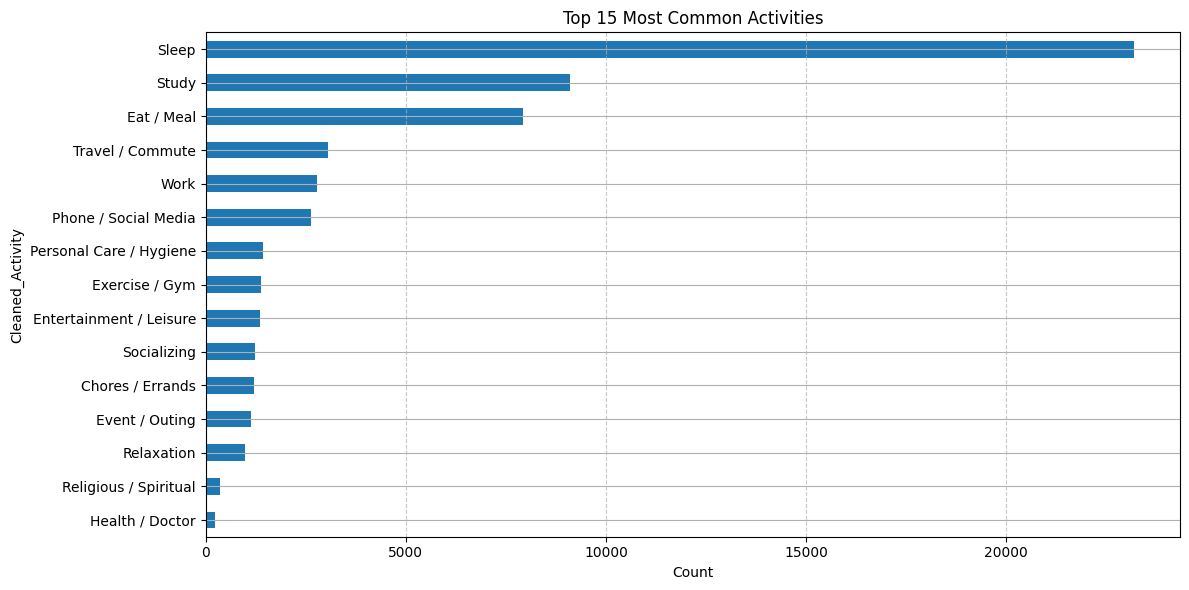

In [23]:
top_activities = master_df['Cleaned_Activity'].value_counts().head(20)

plt.figure(figsize=(12, 6))
top_activities.plot(kind='barh')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Top 15 Most Common Activities')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True)
plt.show()



**Activity vs Average Happiness**

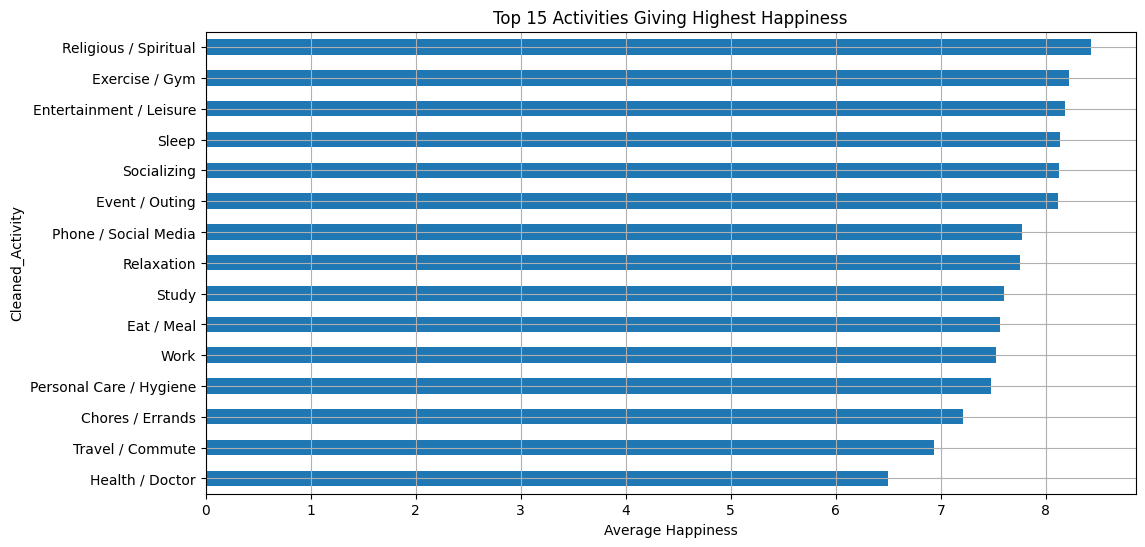

In [24]:
avg_happy_activity = master_df.groupby('Cleaned_Activity')['Happy'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 6))
avg_happy_activity.plot(kind='barh')
plt.title('Top 15 Activities Giving Highest Happiness')
plt.xlabel('Average Happiness')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

**Average Happiness by Hour of Day**

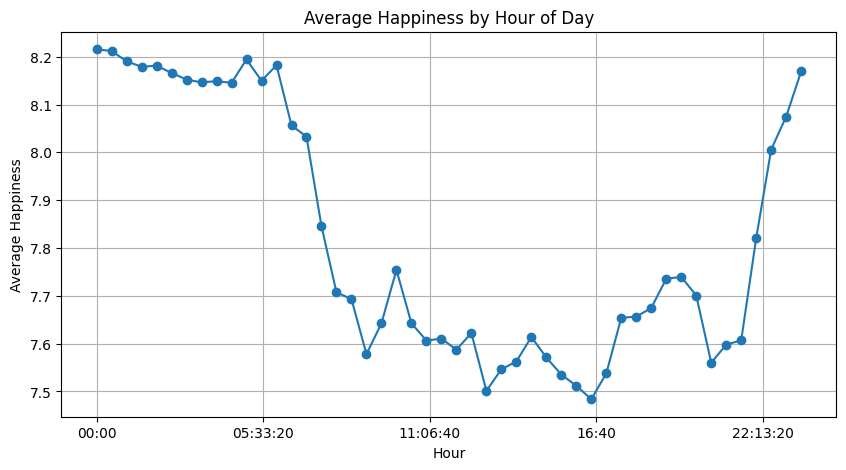

In [25]:
# Extract hour from time if it's datetime
avg_happy_hour = master_df.groupby('Time')['Happy'].mean()

plt.figure(figsize=(10,5))
avg_happy_hour.plot(kind='line', marker='o')
plt.title('Average Happiness by Hour of Day')
plt.ylabel('Average Happiness')
plt.xlabel('Hour')
plt.grid(True)
plt.show()

**Activities Most Common in Each Week**

In [26]:
# Count top 5 activities per week
top_activities = master_df.groupby(['Submission_Week', 'Cleaned_Activity']).size().reset_index(name='Count')

# Optional: pick top 5 activities across ALL weeks for simpler view
top_activities_list = master_df['Cleaned_Activity'].value_counts().head(5).index.tolist()
top_activities = top_activities[top_activities['Cleaned_Activity'].isin(top_activities_list)]

# Plot
fig = px.bar(
    top_activities,
    x='Cleaned_Activity',
    y='Count',
    color='Submission_Week',
    barmode='group',
    title='Top Activities by Submission Week',
    color_discrete_sequence=px.colors.qualitative.Set2
)

fig.update_layout(
    xaxis_title='Activity',
    yaxis_title='Count of Activities',
)

fig.show()


**Average Happiness by Day**

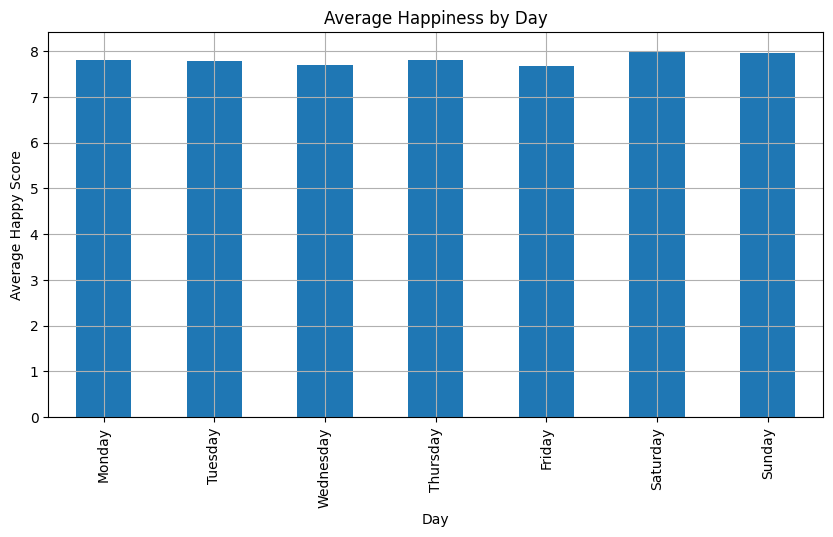

In [27]:
avg_happy_day = master_df.groupby('Day')['Happy'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(10, 5))
avg_happy_day.plot(kind='bar')
plt.title('Average Happiness by Day')
plt.ylabel('Average Happy Score')
plt.grid(True)
plt.show()

**Activity Word Cloud**

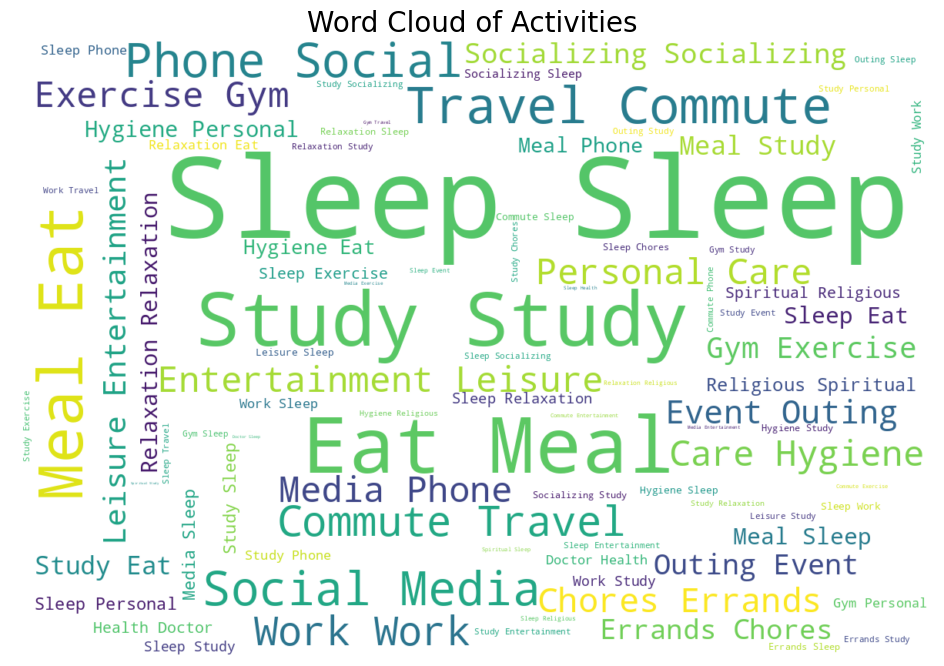

In [28]:
text = " ".join(cleaned_data['Cleaned_Activity'].dropna())

wordcloud = WordCloud(width=1200, height=800, background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Activities', fontsize=20)
plt.show()

**Treemap of Activities by Happiness**

In [29]:
fig = px.treemap(
    cleaned_data,
    path=['Cleaned_Activity'],
    values='Happy',
    color='Happy',
    color_continuous_scale='Blues',
    title='Treemap of Activities weighted by Happiness'
)
fig.show()


/usr/local/lib/python3.11/dist-packages/plotly/express/_core.py:1745: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



# **Hypothesis Testing 1 : Time of Day vs Happiness**

**Null Hypothesis (H₀)**
- There is no difference in average happiness between morning and evening

H₀ : μMorning = μEvening


**Test**
- Group Happy scores by time of day (Morning, Afternoon, Evening).
- Compare average happiness.

In [30]:
# Step 1: Convert 'Time' to a datetime object if not already
master_df['Time'] = pd.to_datetime(master_df['Time'], format='%H:%M:%S').dt.time

In [31]:
# Step 2: Define a function to classify Time into parts of the day
def get_time_of_day(t):
    if pd.isnull(t):  # If time is missing, return 'Unknown' or 'Missing'
        return 'Unknown'
    if t >= pd.to_datetime('05:00:00', format='%H:%M:%S').time() and t < pd.to_datetime('12:00:00', format='%H:%M:%S').time():
        return 'Morning'
    elif t >= pd.to_datetime('12:00:00', format='%H:%M:%S').time() and t < pd.to_datetime('17:00:00', format='%H:%M:%S').time():
        return 'Afternoon'
    elif t >= pd.to_datetime('17:00:00', format='%H:%M:%S').time() and t < pd.to_datetime('22:00:00', format='%H:%M:%S').time():
        return 'Evening'
    else:
        return 'Night'


In [32]:
# Apply it to create a new column
master_df['Time_of_Day'] = master_df['Time'].apply(get_time_of_day)

In [33]:
master_df.head()

,Student_ID,Day,Submission_Week,Time,Activity,Who,Where,Happy,Cleaned_Activity,Time_of_Day
0,4195058507542523866,Monday,Week1,00:00:00,Sleep,Self,Home,7,Sleep,Night
1,4195058507542523866,Monday,Week1,00:30:00,Sleep,Self,Home,7,Sleep,Night
2,4195058507542523866,Monday,Week1,01:00:00,Sleep,Self,Home,7,Sleep,Night
3,4195058507542523866,Monday,Week1,01:30:00,Sleep,Self,Home,7,Sleep,Night
4,4195058507542523866,Monday,Week1,02:00:00,Sleep,Self,Home,7,Sleep,Night


In [34]:
# Step 3: Group by Time_of_Day and calculate average Happiness
happiness_by_time = master_df.groupby('Time_of_Day')['Happy'].mean().reset_index()

In [35]:
# Step 4: Sort for nicer plotting
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
happiness_by_time['Time_of_Day'] = pd.Categorical(happiness_by_time['Time_of_Day'], categories=time_order, ordered=True)
happiness_by_time = happiness_by_time.sort_values('Time_of_Day')

In [36]:
print(happiness_by_time)

  Time_of_Day     Happy
2     Morning  7.828453
0   Afternoon  7.554965
1     Evening   7.64678
3       Night   8.12873
4         NaN  7.881356


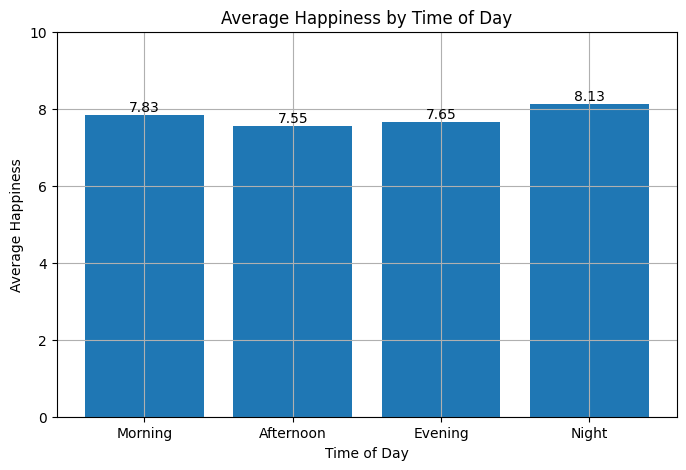

In [37]:
import matplotlib.pyplot as plt

# Drop NaN values and convert to string
happiness_by_time = happiness_by_time.dropna(subset=['Time_of_Day'])
happiness_by_time['Time_of_Day'] = happiness_by_time['Time_of_Day'].astype(str)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(happiness_by_time['Time_of_Day'], happiness_by_time['Happy'])

plt.title('Average Happiness by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Average Happiness')
plt.grid(True)

# Add exact numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

plt.ylim(0, 10)  # Set y-axis limit assuming happiness is out of 10
plt.show()


**Result Interpretation**
- If Evening shows a higher average Happy score than Morning, your hypothesis is supported.
- If not, the hypothesis would be rejected.

**Simple T-test**
- Statistical testing (like a t-test) to formally check if Evening happiness is significantly higher than Morning.


In [38]:
from scipy.stats import ttest_ind

evening_happy = master_df[master_df['Time_of_Day'] == 'Evening']['Happy']
morning_happy = master_df[master_df['Time_of_Day'] == 'Morning']['Happy']

t_stat, p_value = ttest_ind(evening_happy, morning_happy, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: -8.756716211671252, P-value: 2.1289404914693304e-18


**Hypothesis Test Result**:

- A two-sample t-test was conducted to compare student happiness levels in the Morning and Evening.

- The results indicated a statistically significant difference in happiness between the two time periods (t = -8.76, p < 0.001).

- Students reported higher average happiness scores in the Evening compared to the Morning.

- Thus, we reject the null hypothesis and support the alternative hypothesis that students are happier in the evening.

- Students are significantly happier in the evening compared to the morning (p < 0.001).

# **Hypothesis Testing 2: Routine Diversity vs Happiness**

- Routine repetition → Less happiness
- Routine diversity → More happiness

Null Hypothesis (H₀):
- There is no relationship between routine similarity and happiness. (Routine similarity does not affect student happiness.)

Alternative Hypothesis (H₁):
- Students with more similar (repetitive) daily routines report lower happiness levels compared to those with more diverse routines.


Routine Similarity Score:
- For each student, measure how similar their daily routines are across different days (for example, by using string matching or calculating the percentage of repeated activities at the same times).
- High similarity score = very repetitive schedule.
- Low similarity score = more variation/diversity.

Average Happiness Score:
- For each student, take the average of their reported happiness.

Analyze:
- Plot Routine Similarity vs. Happiness.
- Calculate the correlation (like Pearson or Spearman).
- Run a regression to predict happiness based on routine similarity

In [39]:
#Pivot to create a Time vs Activity matrix for each Student and Week
pivot = master_df.pivot_table(
    index=['Student_ID', 'Submission_Week', 'Time'],
    values='Cleaned_Activity',
    aggfunc='first'
).reset_index()

In [40]:
# Step 2: For each Student, compare their routines across Weeks
# Group by Student
similarity_scores = []

for student_id, group in pivot.groupby('Student_ID'):
    # Pivot to have Week1, Week2, Week3 as columns
    student_schedule = group.pivot(index='Time', columns='Submission_Week', values='Cleaned_Activity')

    # Drop times where all weeks are missing
    student_schedule = student_schedule.dropna(how='all')

    # Compare weeks pairwise
    similarities = []
    weeks = student_schedule.columns.tolist()

    for i in range(len(weeks)):
        for j in range(i+1, len(weeks)):
            week1 = student_schedule[weeks[i]]
            week2 = student_schedule[weeks[j]]

            # Only compare where both are not missing
            valid_idx = week1.notna() & week2.notna()
            if valid_idx.sum() == 0:
                continue

            same = (week1[valid_idx] == week2[valid_idx]).sum()
            total = valid_idx.sum()
            sim = same / total
            similarities.append(sim)

    if similarities:
        avg_similarity = np.mean(similarities)
    else:
        avg_similarity = np.nan  # No data

    similarity_scores.append({'Student_ID': student_id, 'Routine_Similarity': avg_similarity})

similarity_df = pd.DataFrame(similarity_scores)

In [41]:
# Step 3: Average Happiness per Student
happiness_df = master_df.groupby('Student_ID')['Happy'].mean().reset_index()
happiness_df.rename(columns={'Happy': 'Average_Happiness'}, inplace=True)

In [42]:
# Step 4: Merge Routine Similarity and Happiness
final_df = pd.merge(similarity_df, happiness_df, on='Student_ID')

In [43]:
# Drop rows with missing similarity (students who have incomplete data)
final_df = final_df.dropna()

final_df.head()

,Student_ID,Routine_Similarity,Average_Happiness
0,322255158917228188,0.680556,7.327381
1,580807617943565636,0.833333,9.543651
2,688813731993989571,0.597222,9.090659
3,795931821777314698,0.847222,7.482143
4,856416271322894007,1.000000,7.181548


In [44]:
# Step 5: Test the Hypothesis (Correlation)
correlation, p_value = pearsonr(final_df['Routine_Similarity'], final_df['Average_Happiness'])

In [45]:
print(f"Pearson Correlation: {correlation:.3f}")
print(f"P-value: {p_value:.6f}")

Pearson Correlation: 0.032
P-value: 0.810845


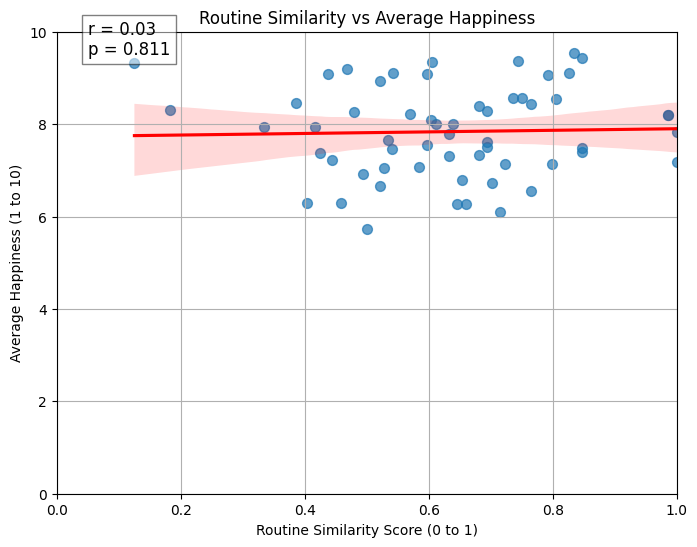

In [46]:
# Step 6: Visualize
plt.figure(figsize=(8, 6))
sns.regplot(
    x='Routine_Similarity',
    y='Average_Happiness',
    data=final_df,
    scatter_kws={'s': 50, 'alpha': 0.7},
    line_kws={'color': 'red'}
)
plt.title('Routine Similarity vs Average Happiness')
plt.xlabel('Routine Similarity Score (0 to 1)')
plt.ylabel('Average Happiness (1 to 10)')
plt.ylim(0, 10)
plt.xlim(0, 1)
plt.grid(True)

# Annotate correlation on the plot
plt.text(0.05, 9.5, f"r = {correlation:.2f}\np = {p_value:.3g}", fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()

**Hypothesis Test Result**:

- A Pearson correlation analysis was conducted to examine the relationship between routine similarity and average happiness.

- The results indicated no significant relationship,
𝑟(52)=0.03, 𝑝=0.811

- Thus, we fail to reject the null hypothesis. Routine similarity does not appear to be significantly associated with happiness levels among students.


# **Hypothesis Testing 3: Entertainment vs Study Trade-off**

Spending time on entertainment and leisure can boost happiness — but only if academic responsibilities, such as studying are not neglected.
The hypothesis tests interaction effect, that is:

*   Does excess entertainment hurt happiness when study time is too low?
*   Is leisure time only helpful when study time is sufficient?

Null Hypothesis (H₀):
- There is no interaction between entertainment/leisure time and study time in predicting happiness.
Spending time on entertainment has the same effect on happiness, regardless of how much time is spent studying.

Alternative Hypothesis (H₁):
- There is an interaction effect between entertainment and study time:
Positive correlation between entertainment time and happiness only when study time is above a threshold.
- If study time is too low, more entertainment might reduce happiness due to guilt, stress, or falling behind.





Aggregation of entertainment and study time per student per day

In [47]:
# Define study and entertainment activity categories
study_activities = ['Study']
entertainment_activities = ['Entertainment / Leisure']

In [48]:
# Create a new column with 0.5-hour time units
master_df['Time'] = pd.to_datetime(master_df['Time'], format='%H:%M:%S').dt.time
master_df['Duration'] = 0.5  # since each entry is 30 minutes

In [49]:
# Calculate total study & entertainment time per student
pivot = master_df.groupby(['Student_ID', 'Cleaned_Activity'])['Duration'].sum().unstack(fill_value=0).reset_index()

In [50]:
# Rename for clarity
pivot['StudyTime'] = pivot.get('Study', 0)
pivot['EntertainmentTime'] = pivot.get('Entertainment / Leisure', 0)

In [51]:
# Add average happiness per student
avg_happy = master_df.groupby('Student_ID')['Happy'].mean().reset_index()
avg_happy.rename(columns={'Happy': 'AverageHappiness'}, inplace=True)

In [52]:
# Merge all
final_df = pd.merge(pivot[['Student_ID', 'StudyTime', 'EntertainmentTime']], avg_happy, on='Student_ID')

In [53]:
# Create interaction term
final_df['Interaction'] = final_df['StudyTime'] * final_df['EntertainmentTime']

Running a linear regression



In [54]:
import statsmodels.formula.api as smf


In [55]:
# Run multiple regression with interaction
model = smf.ols('AverageHappiness ~ StudyTime + EntertainmentTime + Interaction', data=final_df).fit()

In [56]:
# Show summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       AverageHappiness   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9486
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.424
Time:                        02:15:04   Log-Likelihood:                -79.187
No. Observations:                  58   AIC:                             166.4
Df Residuals:                      54   BIC:                             174.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             8.2208      0.56

Visualizing the interaction effect

<Figure size 800x600 with 0 Axes>

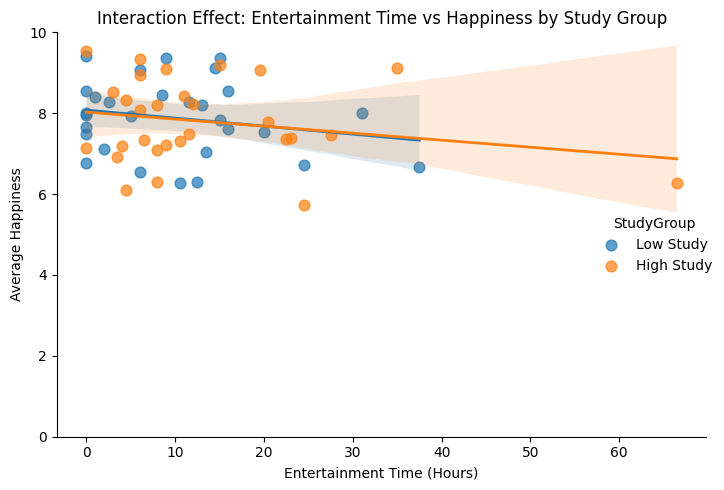

In [57]:
# Split students into high and low study time groups
final_df['StudyGroup'] = pd.qcut(final_df['StudyTime'], q=2, labels=['Low Study', 'High Study'])

# Plot
plt.figure(figsize=(8, 6))
sns.lmplot(
    x='EntertainmentTime',
    y='AverageHappiness',
    hue='StudyGroup',
    data=final_df,
    aspect=1.2,
    scatter_kws={'s': 60, 'alpha': 0.7},
    line_kws={'linewidth': 2}
)
plt.title('Interaction Effect: Entertainment Time vs Happiness by Study Group')
plt.xlabel('Entertainment Time (Hours)')
plt.ylabel('Average Happiness')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()


# **Conclusion**
- Regression equation for the model;

Average_Happiness = 8.2208−0.0022×StudyTime−0.0293×EntertainmentTime+0.0001×(StudyTime×EntertainmentTime)

- P-values: higher than 0.05.
- R-squared of 0.050 shows that the model explains 5% of the variance in AverageHappiness. Hence, a low value indicating weak predictive power, other important factors that could predict happiness have been left out.
- F-statistic p-value,  0.424: The overall model is not statistically significant. It doesn't explain enough variance in happiness to be considered meaningful at conventional levels

- Fail to reject the null hypothesis;

1.   There is no significant interaction between study time and entertainment time in predicting happiness.
2.   Entertainment time does not boost or reduce happiness depending on how much a student studies — at least not in this dataset.

#**Hypothesis Testing 3: Non-Linear Test Model**

A. Quadratic Model: Is happiness curving with more study or more entertainment?

B. Threshhold Analysis: Is there a danger zone of too little study + too much fun?

C. Per-week Model: Does this trade-off vary over time? Are students happier only some weeks when they balance well?


#**A. Quadratic Model(Non-Linear Model): Is the Relationship Curved?**

We will use quadratic terms to capture non-linear behavior like:
- Too much study = burnout
- Too much entertainment = distraction

We will look at the coefficients of StudyTime_sq and EntertainmentTime_sq to see if the effect curves downward or upward.

In [58]:
# Create quadratic terms
final_df['StudyTime_sq'] = final_df['StudyTime'] ** 2
final_df['EntertainmentTime_sq'] = final_df['EntertainmentTime'] ** 2

# Run non-linear regression
quad_model = smf.ols('AverageHappiness ~ StudyTime + EntertainmentTime + StudyTime_sq + EntertainmentTime_sq', data=final_df).fit()

print(quad_model.summary())


                            OLS Regression Results                            
Dep. Variable:       AverageHappiness   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.007
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.412
Time:                        02:15:05   Log-Likelihood:                -78.552
No. Observations:                  58   AIC:                             167.1
Df Residuals:                      53   BIC:                             177.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.6028 

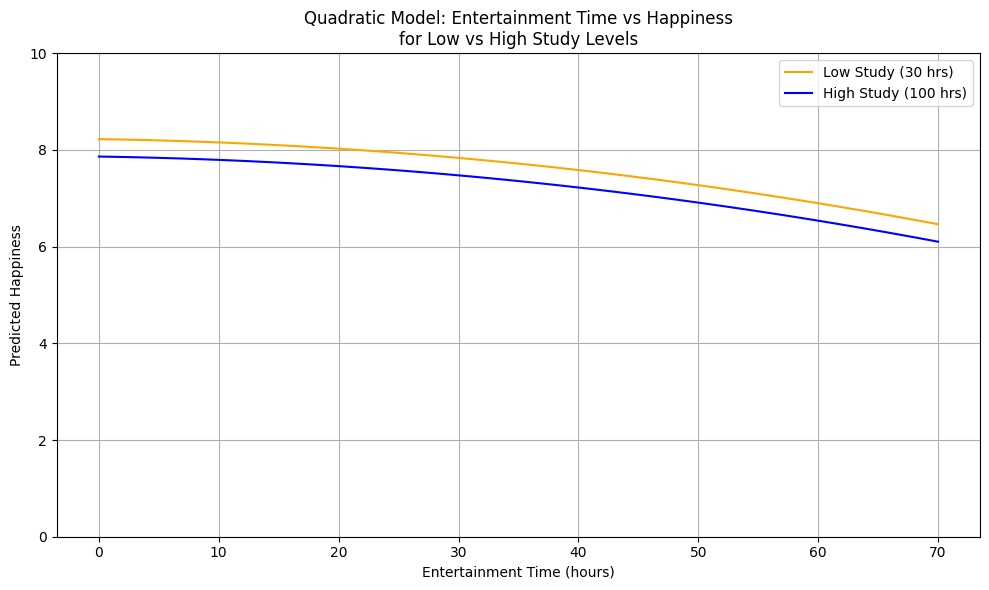

In [59]:
# Step 1: Create a range of entertainment times
entertainment_range = np.linspace(0, 70, 100)

# Step 2: Define low and high study levels
low_study = 30
high_study = 100

# Step 3: Use the quadratic model to predict happiness
def predict_happiness(study, entertainment):
    return (
        quad_model.params['Intercept']
        + quad_model.params['StudyTime'] * study
        + quad_model.params['EntertainmentTime'] * entertainment
        + quad_model.params['StudyTime_sq'] * (study ** 2)
        + quad_model.params['EntertainmentTime_sq'] * (entertainment ** 2)
    )

# Predictions
low_study_pred = [predict_happiness(low_study, e) for e in entertainment_range]
high_study_pred = [predict_happiness(high_study, e) for e in entertainment_range]

# Step 4: Plot
plt.figure(figsize=(10, 6))

plt.plot(entertainment_range, low_study_pred, label=f'Low Study ({low_study} hrs)', color='orange')
plt.plot(entertainment_range, high_study_pred, label=f'High Study ({high_study} hrs)', color='blue')

plt.title('Quadratic Model: Entertainment Time vs Happiness\nfor Low vs High Study Levels')
plt.xlabel('Entertainment Time (hours)')
plt.ylabel('Predicted Happiness')
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Conclusion**
- Plot - we see that As entertainment time increases, predicted happiness decreases slightly — regardless of study level.
- Excessive entertainment time is mildly associated with lower happiness, especially for those who already study a lot.
- High-study students might experience more burnout or guilt with more entertainment.
- However, the overall decline is gentle, and the regression model did not find this effect statistically significant.
- StudyTime_sq - 0.407 (Not significant — no curving effect of study time)
- EntertainmentTime_sq - 0.518 (Not significant — no curving effect of entertainment)
- No significant non-linear (curved) relationship was detected. The happiness-stress "curve" hypothesis is not supported.

#**B. Threshold-Based Group Comparison**

Let’s test if there’s a “bad combo” zone:
- Study time < 50 hrs
-Entertainment time > 0 hrs
- → Are these students significantly less happy?

In [60]:
# Create flag for threshold group
final_df['LowStudy_HighEntertainment'] = (
    (final_df['StudyTime'] < 50) & (final_df['EntertainmentTime'] > 0)
)

# Compare average happiness
group_stats = final_df.groupby('LowStudy_HighEntertainment')['AverageHappiness'].describe()
print(group_stats)

# Run t-test
from scipy.stats import ttest_ind

group1 = final_df[final_df['LowStudy_HighEntertainment']]['AverageHappiness']
group2 = final_df[~final_df['LowStudy_HighEntertainment']]['AverageHappiness']

t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")


                            count      mean       std       min       25%  \
LowStudy_HighEntertainment                                                  
False                        49.0  7.830264  0.999881  5.732143  7.181548   
True                          9.0  7.877641  0.924667  6.660714  7.126984   

                                 50%       75%       max  
LowStudy_HighEntertainment                                
False                       7.821429   8.53373  9.543651  
True                             8.0  8.396825  9.107584  
T-statistic: 0.14, P-value: 0.8915


**Groups:**

- All Others = Students who either studied ≥ 50 hrs or had no entertainment
- Low Study + Some Entertainment = Students who studied < 50 hrs and had some entertainment

<ipython-input-61-ae4248f25450>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




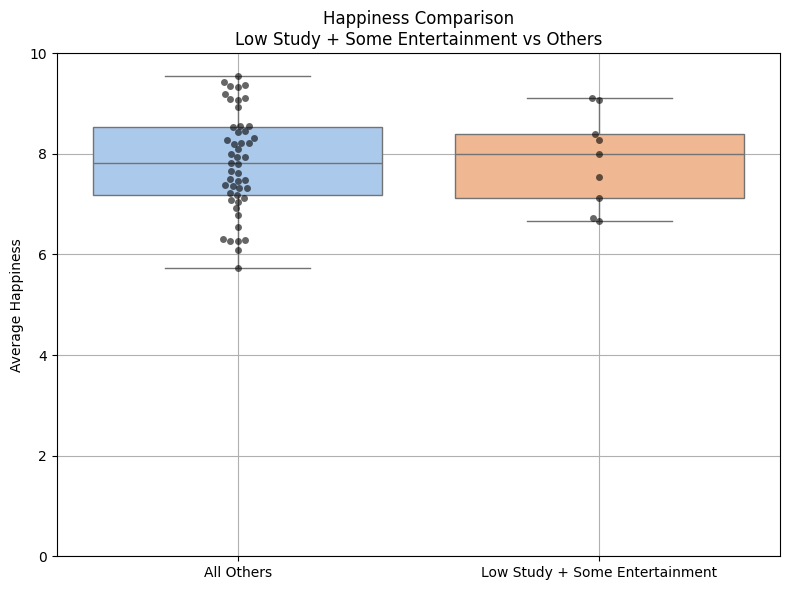

In [61]:
# Clean up the label for readability
final_df['Group_Label'] = final_df['LowStudy_HighEntertainment'].map({
    True: 'Low Study + Some Entertainment',
    False: 'All Others'
})

# Plot the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group_Label', y='AverageHappiness', data=final_df, palette='pastel')
sns.swarmplot(x='Group_Label', y='AverageHappiness', data=final_df, color='black', alpha=0.6)

# Titles and labels
plt.title('Happiness Comparison\nLow Study + Some Entertainment vs Others')
plt.xlabel('')
plt.ylabel('Average Happiness')
plt.ylim(0, 10)
plt.grid(True)
plt.tight_layout()
plt.show()


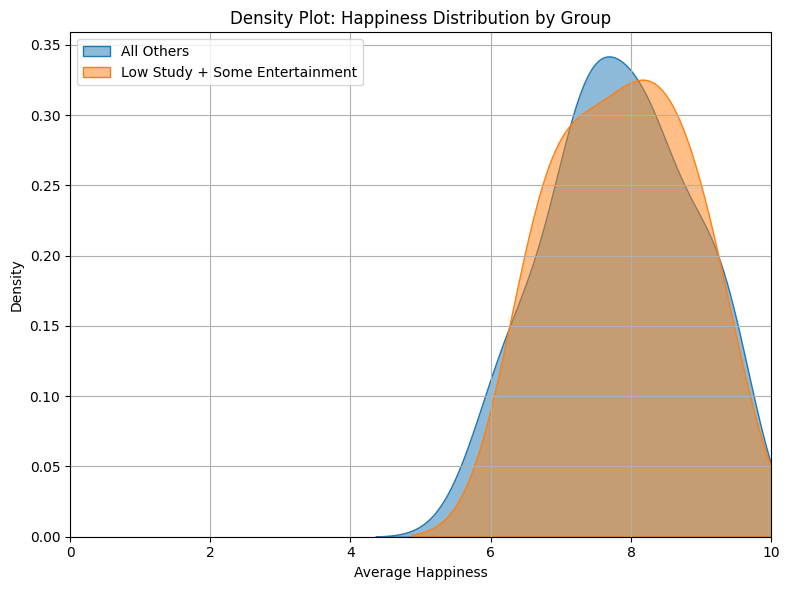

In [62]:
plt.figure(figsize=(8, 6))
for label, group_data in final_df.groupby('Group_Label'):
    sns.kdeplot(group_data['AverageHappiness'], label=label, fill=True, alpha=0.5)

plt.title('Density Plot: Happiness Distribution by Group')
plt.xlabel('Average Happiness')
plt.ylabel('Density')
plt.xlim(0, 10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Students in the low study + entertainment group have slightly lower median happiness, but the difference is very small.
- There's also a lot of overlap — suggesting any difference is not statistically significant (which matches your t-test results).

**Conclusion**

- Group: students with average Study < 50 hours AND Entertainment > 0 hours
- T-statistic: 0.14, P-value: 0.8915


#**C. Per-Week Analysis**

Let’s repeat the interaction model week-by-week (Week1, Week2, Week3)
- This helps uncover patterns that could be lost in averages.

Here, we're looking to see if Week2 or Week3 had a stronger interaction than Week1.



In [63]:
results = {}

for week in master_df['Submission_Week'].unique():
    week_df = master_df[master_df['Submission_Week'] == week]

    # Sum durations for each student
    pivot_week = week_df.groupby(['Student_ID', 'Cleaned_Activity'])['Duration'].sum().unstack(fill_value=0).reset_index()
    pivot_week['StudyTime'] = pivot_week.get('Study', 0)
    pivot_week['EntertainmentTime'] = pivot_week.get('Entertainment / Leisure', 0)

    # Merge with happiness
    happy_week = week_df.groupby('Student_ID')['Happy'].mean().reset_index()
    happy_week.rename(columns={'Happy': 'AverageHappiness'}, inplace=True)

    merged = pd.merge(pivot_week[['Student_ID', 'StudyTime', 'EntertainmentTime']], happy_week, on='Student_ID')
    merged['Interaction'] = merged['StudyTime'] * merged['EntertainmentTime']

    # Run model
    model = smf.ols('AverageHappiness ~ StudyTime + EntertainmentTime + Interaction', data=merged).fit()
    results[week] = model.summary()

# Show all 3 summaries
for week, summary in results.items():
    print(f"\n Results for {week}")
    print(summary)



 Results for Week1
                            OLS Regression Results                            
Dep. Variable:       AverageHappiness   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.211
Date:                Thu, 24 Apr 2025   Prob (F-statistic):              0.315
Time:                        02:15:06   Log-Likelihood:                -78.363
No. Observations:                  57   AIC:                             164.7
Df Residuals:                      53   BIC:                             172.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         

<Figure size 1000x600 with 0 Axes>

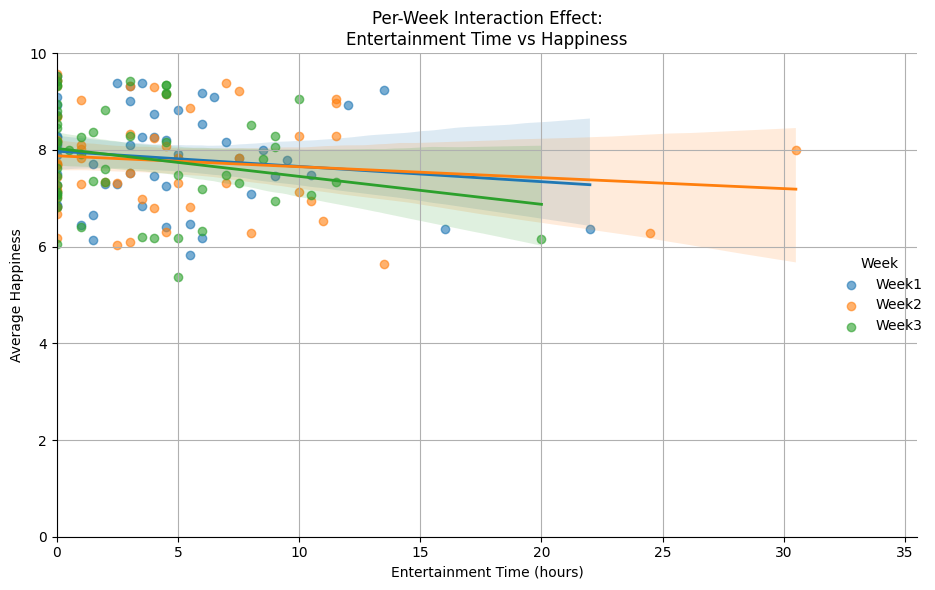

In [64]:
# Container for weekly merged data
weekly_data = []

# Step 1: Collect merged data per week
for week in master_df['Submission_Week'].unique():
    week_df = master_df[master_df['Submission_Week'] == week]

    pivot_week = week_df.groupby(['Student_ID', 'Cleaned_Activity'])['Duration'].sum().unstack(fill_value=0).reset_index()
    pivot_week['StudyTime'] = pivot_week.get('Study', 0)
    pivot_week['EntertainmentTime'] = pivot_week.get('Entertainment / Leisure', 0)

    happy_week = week_df.groupby('Student_ID')['Happy'].mean().reset_index()
    happy_week.rename(columns={'Happy': 'AverageHappiness'}, inplace=True)

    merged = pd.merge(pivot_week[['Student_ID', 'StudyTime', 'EntertainmentTime']], happy_week, on='Student_ID')
    merged['Interaction'] = merged['StudyTime'] * merged['EntertainmentTime']
    merged['Week'] = week

    weekly_data.append(merged)

# Step 2: Combine all weekly data
combined_weeks_df = pd.concat(weekly_data, ignore_index=True)

# Step 3: Plot interaction trend per week
plt.figure(figsize=(10, 6))
sns.lmplot(
    x='EntertainmentTime',
    y='AverageHappiness',
    hue='Week',
    data=combined_weeks_df,
    aspect=1.4,
    height=6,
    scatter_kws={'alpha': 0.6},
    line_kws={'linewidth': 2}
)

plt.title('Per-Week Interaction Effect:\nEntertainment Time vs Happiness')
plt.xlabel('Entertainment Time (hours)')
plt.ylabel('Average Happiness')
plt.ylim(0, 10)
plt.xlim(0, combined_weeks_df['EntertainmentTime'].max() + 5)
plt.grid(True)
plt.tight_layout()
plt.show()


**Straightforward Interpretation:**

- Week 1 (blue): Slight negative slope → More entertainment = slightly less happiness
- Week 2 (orange): Nearly flat → Entertainment has no real effect on happiness
- Week 3 (green): Noticeably negative slope → More entertainment = lower happiness

Across all weeks, entertainment time shows no strong or consistent effect on happiness. No week clearly supports the idea that entertainment-happiness depends on study balance.

**Conclusion**

Interaction p-value
- Week 1 - 0.120 (Closest to significant — some weak signs of interaction)
- Week 2 - 0.581 (No effect at all)
- Week 3 - 0.190 (Slight negative entertainment effect (p = 0.061) but interaction still not significant)

#**Final Conclusion**

Based on the regression models, non-linear testing, and weekly breakdowns, there is insufficient evidence to support the hypothesis that study time moderates the relationship between entertainment time and happiness.

Therefore, we fail to reject the null hypothesis.
